In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from cot.data import Parity, BinaryCopy, Copy
from cot.config import RAW_DIR
from cot.models import Transformer, TransformerConfig

import logging
logging.basicConfig(level=logging.INFO)

## DataLoader

In [3]:
Problem = Parity

In [4]:
rng = np.random.default_rng()
nb_len = 8
lengths = list(np.arange(nb_len) + 1)

split_probas_by_len =  .75 * np.ones(len(lengths))
probas_by_len = np.ones(len(lengths), dtype=float)
probas_by_len /= probas_by_len.sum()

max_nb_data_per_len = 10000

In [5]:
if Problem.prefix == 'copy':
    Problem(vocab_size=20)

# Problem.generate_datafiles(max_nb_data_per_len, split_probas_by_len, rng)

trainset = Problem()
trainset.set_as_trainset(lengths, probas_by_len)

testset = Problem()
testset.set_as_testset(lengths)

INFO:cot.data.data_processing:Loading training data for parity problem.
INFO:cot.data.data_processing:Setting sampler.
INFO:cot.data.data_processing:Loading test data for parity problem.


In [6]:
loader = DataLoader(trainset, batch_size=len(trainset), sampler=trainset.sampler)
print(f"number of data: {len(trainset)}")

number of data: 382


## Training loop

In [7]:
config = TransformerConfig(
    vocab_size=torch.max(trainset.data).item() + 1,
    emb_dim=128,
    pos_emb=True,
    seq_len=len(trainset[0]),
    emb_dropout=0.1,
    n_head=2,
    n_layer=2,
)

In [8]:
model = Transformer(config)
print(model)

Transformer(
  (embeddings): Embedding(
    (token_emb): Embedding(5, 128)
    (pos_emb): Embedding(19, 128)
  )
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv_mat): Linear(in_features=128, out_features=384, bias=False)
        (output): Linear(in_features=128, out_features=128, bias=False)
      )
      (norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (fc1): Linear(in_features=128, out_features=512, bias=False)
        (fc2): Linear(in_features=512, out_features=128, bias=False)
      )
    )
  )
  (output_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=128, out_features=5, bias=False)
)


In [9]:
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = Transformer(config)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

nb_epochs = 300

losses = np.empty(nb_epochs)
acc_by_len = np.empty((nb_epochs, len(lengths))) 
test_acc_by_len = np.empty((nb_epochs, len(lengths)))
spe_acc = np.empty((nb_epochs, 3)) 
test_spe_acc = np.empty((nb_epochs, 3)) 
test_losses = []

for t in range(nb_epochs):
    model.train()
    running_loss = 0
    accuracy = 0
    for sequence in loader:
        sequence = sequence.to(device=device, dtype=torch.long)

        inputs = sequence[:, :-1]
        targets = sequence[:, 1:]

        # only train on the chain-of-thoughts process, EoI is represented by 1 in our case
        ind = targets == 1
        cot_mask = ind.cumsum(axis=1)
        cot_mask[ind] = 0
        cot_mask = cot_mask.to(dtype=bool)

        logits = model(inputs)
        loss = F.cross_entropy(logits[cot_mask].view(-1, logits.size(-1)), targets[cot_mask].reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            running_loss += loss.item()

    with torch.no_grad():
        model.eval()
        _, seq_err, spe_err = trainset.eval_model(model, special=True)
        _, test_seq_err, test_spe_err = testset.eval_model(model, special=True)
        accuracy = 1 - (seq_err * probas_by_len).sum().item()
        test_accuracy = 1 - (test_seq_err * probas_by_len).sum().item()

    acc_by_len[t] = 1 - seq_err.numpy()
    test_acc_by_len[t] = 1 - test_seq_err.numpy()
    test_acc_by_len[t] = 1 - test_seq_err.numpy()
    spe_acc[t] = 1 - spe_err
    test_spe_acc[t] = 1 - test_spe_err
    losses[t] = loss
    print(f'Epoch {t:5d}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.4f}, {test_accuracy:.4f}')

cpu


/home/vivc/Code/conda/envs/llm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch     0, Loss: 1.8271, Accuracy: 0.0000, 0.0000
Epoch     1, Loss: 1.1299, Accuracy: 0.1667, 0.0000
Epoch     2, Loss: 0.7305, Accuracy: 0.1667, 0.0000
Epoch     3, Loss: 0.5938, Accuracy: 0.0417, 0.0039
Epoch     4, Loss: 0.5158, Accuracy: 0.0430, 0.0000
Epoch     5, Loss: 0.4773, Accuracy: 0.0423, 0.0000
Epoch     6, Loss: 0.4622, Accuracy: 0.0000, 0.0000
Epoch     7, Loss: 0.4483, Accuracy: 0.0007, 0.0000
Epoch     8, Loss: 0.4450, Accuracy: 0.0423, 0.0000
Epoch     9, Loss: 0.4431, Accuracy: 0.0443, 0.0000
Epoch    10, Loss: 0.4026, Accuracy: 0.1693, 0.0000
Epoch    11, Loss: 0.3727, Accuracy: 0.1693, 0.0000
Epoch    12, Loss: 0.4143, Accuracy: 0.1693, 0.0000
Epoch    13, Loss: 0.4057, Accuracy: 0.2168, 0.0000
Epoch    14, Loss: 0.4081, Accuracy: 0.2135, 0.0020
Epoch    15, Loss: 0.3823, Accuracy: 0.2116, 0.0000
Epoch    16, Loss: 0.3894, Accuracy: 0.2122, 0.0000
Epoch    17, Loss: 0.3524, Accuracy: 0.2116, 0.0000
Epoch    18, Loss: 0.3556, Accuracy: 0.2116, 0.1250
Epoch    19,

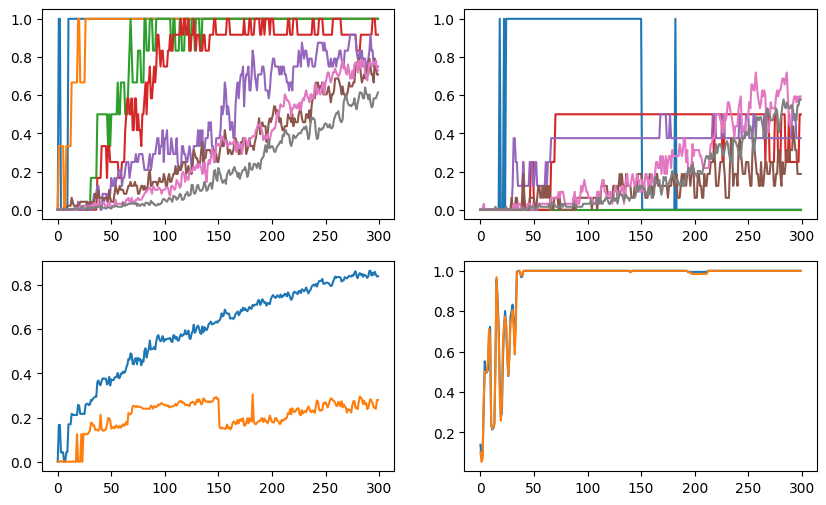

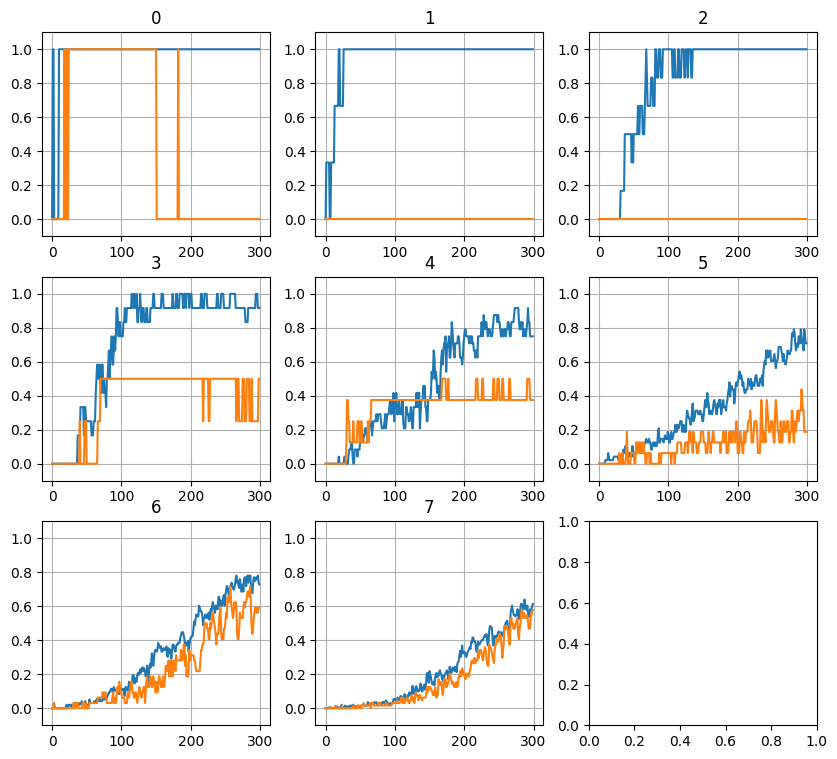

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0, 0].plot(acc_by_len)
axes[0, 1].plot(test_acc_by_len)
axes[1, 0].plot(acc_by_len.mean(axis=1))
axes[1, 0].plot(test_acc_by_len.mean(axis=1))
axes[1, 1].plot(spe_acc[:, 2])
axes[1, 1].plot(test_spe_acc[:, 2])
# axes[1, 1].set_xlim(0, 50)

fig, axes = plt.subplots(nb_len // 3 + (1 if nb_len % 3 else 0), 3, figsize=(10, 9))
for i in range(nb_len):
    axes[i // 3, i % 3].plot(acc_by_len[:, i])
    axes[i // 3, i % 3].plot(test_acc_by_len[:, i])
    axes[i // 3, i % 3].set_ylim(-.1, 1.1)
    axes[i // 3, i % 3].set_title(i)
    axes[i // 3, i % 3].grid()